In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import series_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from hmmlearn import hmm
import hmm_helper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
import itertools

In [230]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)

In [ ]:
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [ ]:
def get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer):    

    subject_list = []
    all_data = []
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        series = series.T
        series['network'] = schafer['network']
        series_nolimbic = series[series.network!='Limbic']
        del series_nolimbic["network"]
        df_series = series_nolimbic.T
        all_data.append(df_series.values)
        subject_list.append(subject)
  
    return all_data, subject_list
    

def get_all_data(scans, stimuli,subjects, dirpath, parcel,schafer): 
    all_c = []
    all_subjects = []

    for scan in scans:

        for stimulus in stimuli:
  
            all_data, subject_list = get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer)
            all_subjects = all_subjects +  subject_list
            all_c = all_c + all_data
          
    return all_c, all_subjects

In [228]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Matriz de confusión', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
#    cbar.ax.set_yticklabels(['< -1', '0', '> 1']) 
    cbar = plt.colorbar(ticks=[-1, 1])
    cbar.ax.set_yticklabels([cm.min(), cm.max()]) 
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2. + 0.1
    print(thresh)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
                 
    plt.tight_layout()
    plt.ylabel('Valores Reales')
    plt.xlabel('Valores Predicción')

In [ ]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='Curva ROC (area = %.2f)' %auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
    plt.title('curva ROC')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderros positivos')
    plt.grid()
    plt.legend()
    plt.show()

# Average pre

In [ ]:
occ_pre, subjects_list_occ_pre = get_all_data(['_scan_restpre'], ['ses-occ'], subjects, dirpath, parcel,schafer)
fro_pre, subjects_list_fro_pre = get_all_data(['_scan_restpre'], ['ses-fro'], subjects, dirpath, parcel,schafer)


pre_average = list((np.array(fro_pre) + np.array(occ_pre))/2)

## OCC

In [171]:
occ_post, subjects_list_occ_post =  get_all_data(['_scan_restpost'], ['ses-occ'], subjects, dirpath, parcel,schafer)

In [172]:
all_occ = pre_average + occ_post
subjects_occ = subjects_list_occ_pre + subjects_list_occ_post
y_occ = [0]*len(subjects_list_occ_pre) + [1]*len(subjects_list_occ_post)

In [173]:
cat_subjects = pd.get_dummies(subjects_occ)

subjects_id_occ = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']

In [174]:
X_occ = np.swapaxes(np.swapaxes(np.dstack(all_occ), 0,2),1,2)
y_occ = np.array(y_occ)

X_occ.shape

(46, 600, 376)

In [ ]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm")
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)],
                'model__n_mix': [*range(2,10)]
}


In [ ]:
grid_search_m_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 3,n_jobs=-1)

grid_search_m_occ.fit(X = X_occ, y = y_occ, groups = subjects_id_occ)

In [ ]:
print('Best Score: %s' % grid_search_m_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_m_occ.best_params_)

In [ ]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,21)]
}

In [ ]:
grid_search_m_occ.cv_results_

In [ ]:
grid_search_g_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_occ.fit(X = X_occ, y = y_occ, groups = subjects_id_occ)

In [ ]:
grid_search_g_occ.cv_results_

In [ ]:
print('Best Score: %s' % grid_search_g_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_occ.best_params_)

### Best model

In [156]:
states = 8
n_mix = 2

base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states,n_mix=n_mix)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_occ = cross_val_score(pipe, X_occ, y_occ, cv = cv, scoring='accuracy', groups = subjects_id_occ)
y_score_occ = cross_val_predict(pipe,  X_occ, y_occ, cv = cv ,method='predict_proba', groups = subjects_id_occ)
y_pred_occ = cross_val_predict(pipe,  X_occ, y_occ, cv = cv, groups = subjects_id_occ,n_jobs=-1)


In [162]:
scores_occ.mean()

0.8043478260869565

In [163]:
y_score_p = y_score_occ[:,1]-y_score_occ[:,0]
auc = metrics.roc_auc_score(y_occ, y_score_p)
auc

0.8771266540642723

In [164]:
error = proportion_confint(np.sum(np.equal(y_pred_occ,y_occ)),len(y_occ),method='jeffreys')
error

(0.6732673470246978, 0.8985338681614017)

In [165]:
fpr, tpr, thresh = metrics.roc_curve(y_occ, y_score_p)

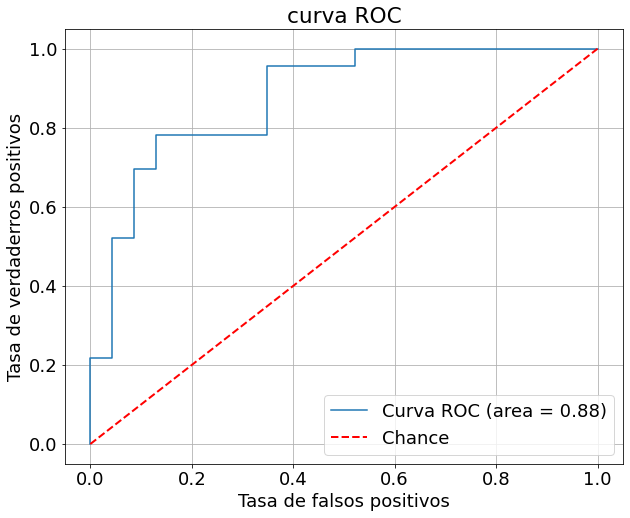

In [166]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [167]:
accuracy_score(y_pred_occ,y_occ)
print(proportion_confint(np.sum(np.equal(y_pred_occ,y_occ)),len(y_occ),method='jeffreys'))
cm = confusion_matrix(y_pred_occ,y_occ)


(0.6732673470246978, 0.8985338681614017)


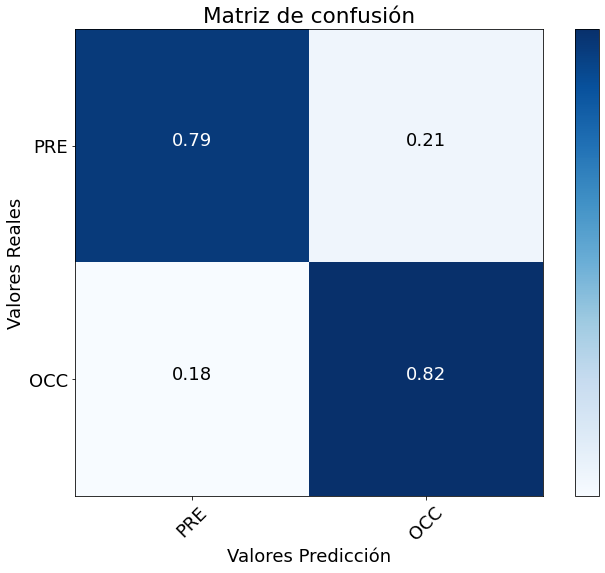

In [168]:

plot_confusion_matrix(cm, ["PRE", "OCC"],normalize=True)

## FRO

In [178]:
fro_post, subjects_list_fro_post =  get_all_data(['_scan_restpost'], ['ses-fro'], subjects, dirpath, parcel,schafer)


all_fro = pre_average + fro_post
subjects_fro = subjects_list_fro_pre + subjects_list_fro_post
y_fro = [0]*len(subjects_list_fro_pre) + [1]*len(subjects_list_fro_post)


cat_subjects = pd.get_dummies(subjects_fro)

subjects_id_fro = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Fro']

X_fro = np.swapaxes(np.swapaxes(np.dstack(all_fro), 0,2),1,2)
y_fro = np.array(y_fro)

X_fro.shape

(46, 600, 376)

###  GRID SEARCH

In [ ]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm")
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)],
                'model__n_mix': [*range(2,10)]
}

In [ ]:
grid_search_m_fro = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 1,n_jobs=-1)

grid_search_m_fro.fit(X = X_fro, y = y_fro, groups = subjects_id_fro)

In [ ]:
print('Best Score: %s' % grid_search_m_fro.best_score_)
print('Best Hyperparameters: %s' % grid_search_m_fro.best_params_)

In [ ]:
base_model = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)]}

In [ ]:
grid_search_g_fro = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro.fit(X = X_fro, y = y_fro, groups = subjects_id_fro)

In [ ]:
grid_search_g_fro.cv_results_

In [ ]:
print('Best Score: %s' % grid_search_g_fro.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro.best_params_)

## BEST MODEL

In [ ]:
states = 10
base_model = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores = cross_val_score(pipe, X_fro, y_fro, cv = cv, scoring='accuracy', groups = subjects_id_fro,n_jobs=-1)
y_score = cross_val_predict(pipe,  X_fro, y_fro, cv = cv ,method='predict_proba', groups = subjects_id_fro,n_jobs=-1)
y_pred = cross_val_predict(pipe,  X_fro, y_fro, cv = cv, groups = subjects_id_fro,n_jobs=-1)



In [ ]:
scores.mean()

In [ ]:
y_score_p = y_score[:,1]-y_score[:,0]
auc = metrics.roc_auc_score(y_occ, y_score_p)
auc

In [ ]:
error = proportion_confint(np.sum(np.equal(y_pred,y_occ)),len(y_occ),method='jeffreys')
error

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [ ]:
fpr, tpr, thresh = metrics.roc_curve(y_occ, y_score_p)

In [ ]:
accuracy_score(y_pred,y_occ)
print(proportion_confint(np.sum(np.equal(y_pred,y_occ)),len(y_occ),method='jeffreys'))
cm = confusion_matrix(y_pred,y_occ)

In [ ]:
plot_confusion_matrix(cm, ["PRE", "OCC"],normalize=True)

## FRO VS CTR

In [231]:
diff_occ = list(np.array(occ_post)- np.array(pre_average))
diff_fro = list(np.array(fro_post)- np.array(pre_average))

diff_occ = occ_post
diff_fro = fro_post

subjects_diff = subjects_list_occ_post + subjects_list_fro_post
y_diff = [0]*len(subjects_list_occ_post) + [1]*len(subjects_list_fro_post)

all_diff = diff_occ + diff_fro
X_diff = np.swapaxes(np.swapaxes(np.dstack(all_diff), 0,2),1,2)
y_diff = np.array(y_diff)

In [232]:
X_diff.shape

(46, 600, 376)

In [235]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm")
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,18)],
                'model__n_mix': [*range(2,10)]
}

In [236]:
grid_search_fro_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 3,n_jobs=-1)

grid_search_fro_occ.fit(X = X_diff, y = y_diff, groups = subjects_diff)

Fitting 23 folds for each of 80 candidates, totalling 1840 fits
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=1.000 total time=  24.0s
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  21.6s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=1.000 total time=  21.8s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 15

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=3;, score=1.000 total time=  28.8sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  27.8s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=1.000 total time=  23.1s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.000 total time=  21.7s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params

GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  23.8s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  24.5s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  22.2s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 17/2

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=3;, score=0.500 total time=  26.5sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=1.000 total time=  23.7s
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  24.5s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  23.5s
GMMHMM(init_params='cm', n_components=8, n_mix=4, param

GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  26.4s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  19.9s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=1.000 total time=  21.0s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 16/2

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  26.2sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  27.1s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=1.000 total time=  23.8s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  23.4s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params=

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=3;, score=0.500 total time=  28.3sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  29.6s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=1.000 total time=  23.0s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  22.8s
GMMHMM(init_params='cm', n_components=8, n_mix=5, param

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  22.9sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=1.000 total time=  29.6s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  20.3s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  22.5s
GMMHMM(init_params='cm', n_components=8, n_mix=4, param

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  24.9sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  28.0s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  24.2s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  23.2s
GMMHMM(init_params='cm', n_components=8, n_mix=5, para

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  28.5sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=1.000 total time=  28.4s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  24.0s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=1.000 total time=  21.9s
GMMHMM(init_params='cm', n_components=8, n_mix=5, params=

[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  29.2sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  29.8s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  22.2s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  24.9s
GMMHMM(init_params='cm', n_components=8, n_mix=5, param

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  27.2sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=1.000 total time=  24.1s
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  25.7s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  21.6s
GMMHMM(init_params='cm', n_components=8, n_mix=4, para

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  28.2sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  26.6s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.000 total time=  24.6s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  24.4s
GMMHMM(init_params='cm', n_components=8, n_mix=5, params=

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=1.000 total time=  30.6sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  30.2s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  23.7s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  22.3s
GMMHMM(init_params='cm', n_components=8, n_mix=5, param

GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.000 total time=  28.1s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  24.3s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  21.6s
GMMHMM(init_params='cm', n_components=8, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=5, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), m

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  24.4sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  28.9s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  23.9s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=0.500 total time=  24.6s
GMMHMM(init_params='cm', n_components=8, n_mix=5, param

GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=0.500 total time=  27.3s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=1.000 total time=  24.7s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=1.000 total time=  25.6s
GMMHMM(init_params='cm', n_components=8, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=5, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), mo

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  27.5sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2;, score=1.000 total time=  28.1s
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=3, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=3;, score=0.500 total time=  24.2s
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=4, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=4;, score=1.000 total time=  24.5s
GMMHMM(init_params='cm', n_components=8, n_mix=5, params

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.000 total time=  28.0s
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  28.5s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  25.9s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=1.000 total time=  29.6s
GMMHMM(init_params='cm', n_components=11, n_mi

GMMHMM(init_params='cm', n_components=14, n_mix=6, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=1.000 total time=  28.9s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=1.000 total time=  28.7s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  26.4s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 to

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6;, score=1.000 total time=  36.0s
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=1.000 total time=  28.1s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  27.6s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  23.3s
GMMHMM(init_params='cm', n_components=11, n_m

GMMHMM(init_params='cm', n_components=14, n_mix=6, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=1.000 total time=  26.3s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  29.8s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  29.8s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 to

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6;, score=0.500 total time=  36.5s
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  28.7s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=1.000 total time=  30.1s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  29.4s
GMMHMM(init_params='cm', n_components=11, n_

GMMHMM(init_params='cm', n_components=14, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=4, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=4;, score=0.500 total time=  26.0s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=1.000 total time=  29.0s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=1.000 total time=  30.6s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=1.000 total time=  29.7s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  24.5s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=1.000 total time=  27.7s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  25.6s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.000 total time=  30.5s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  26.6s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  29.6s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  30.5s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  30.2s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 t

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.000 total time=  32.1s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  29.4s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  28.4s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=1.000 total time=  29.7s
GMMHMM(init_params='cm', n_components=11, n_mi

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  28.9s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  29.0s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  31.3s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm'

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  28.5s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  29.7s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  30.1s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=1.000 total time=  28.8s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=1.000 total time=  29.0s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  29.0s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm'

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=1.000 total time=  26.4s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  29.0s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  30.9s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='c

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  27.8s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  26.1s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  31.5s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='c

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  29.1s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  30.4s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=1.000 total time=  28.6s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  30.6s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  27.1s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=1.000 total time=  25.2s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='

GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  30.0s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=1.000 total time=  30.4s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.000 total time=  30.4s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8;, score=0.500 tota

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  34.4s
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  30.0s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  29.2s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=0.500 total time=  30.4s
GMMHMM(init_params='cm', n_components=11, n_

GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=5, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5;, score=0.500 total time=  29.6s
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=6, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6;, score=0.500 total time=  30.6s
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=7, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7;, score=1.000 total time=  31.6s
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=11, n_mix=8, params='

GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6;, score=1.000 total time=  37.2s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  39.6s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.3s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 to

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=8;, score=1.000 total time=  49.2s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  39.5s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.7s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.1s
GMMHMM(init_params='cm', n_components=14, n_mi

GMMHMM(init_params='cm', n_components=17, n_mix=8, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  35.5s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=1.000 total time=  37.5s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  39.0s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=8;, score=0.500 total time=  47.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6;, score=1.000 total time=  36.6s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=1.000 total time=  36.7s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.7s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_p

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=8;, score=0.500 total time=  47.9s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  38.0s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.6s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=1.000 total time=  36.8s
GMMHMM(init_params='cm', n_components=15, n_m

GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6;, score=0.500 total time=  36.7s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  36.3s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  36.4s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  43.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  37.8s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=1.000 total time=  38.2s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.000 total time=  39.6s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 4/23] END model__hmm_model=GMMHMM(init_para

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=1.000 total time=  46.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  38.1s
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=7, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  36.1s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  39.3s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_pa

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  47.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  37.3s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  39.0s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  40.8s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 22/23] END model__hmm_model=GMMHMM(init_par

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  47.0s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=1.000 total time=  37.3s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=1.000 total time=  37.3s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  39.5s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 23/23] END model__hmm_model=GMMHMM(init_par

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  46.1s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  35.9s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=1.000 total time=  37.9s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  39.4s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 3/23] END model__hmm_model=GMMHMM(init_par

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=1.000 total time=  42.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  39.1s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.4s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  39.3s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 5/23] END model__hmm_model=GMMHMM(init_pa

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  42.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=1.000 total time=  35.7s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=1.000 total time=  37.4s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  38.5s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 9/23] END model__hmm_model=GMMHMM(init_p

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=1.000 total time=  39.7s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  36.9s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.4s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=1.000 total time=  38.2s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_par

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  41.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  38.8s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.9s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  37.7s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_p

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  32.3s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.000 total time=  40.0s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  41.3s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  38.9s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_pa

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  32.3sGMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=8, n_mix=2, params='cm')


GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('lda', LinearDiscriminantAnalysis3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GMMHMM(init_params='cm',
                                                                        params='cm')))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GMMHMM(init_params='cm',
                                                     params='cm')],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14, 15,
                                                 16, 17],
                         'model__n_mix': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy', verbose=3)

In [237]:
print('Best Score: %s' % grid_search_fro_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_fro_occ.best_params_)

Best Score: 0.6086956521739131
Best Hyperparameters: {'model__hmm_model': GMMHMM(init_params='cm', params='cm'), 'model__n_components': 8, 'model__n_mix': 2}


In [238]:
grid_search_fro_occ.cv_results_

{'mean_fit_time': array([26.66614984, 23.14166451, 23.48054921, 24.4725148 , 24.79014455,
        25.97996278, 25.82042391, 26.2362437 , 24.38679865, 25.56573602,
        27.57101715, 26.34367497, 28.26918757, 26.7614767 , 29.22062835,
        24.69207857, 25.45943222, 25.80687885, 25.34671546, 26.1038675 ,
        25.96883953, 27.22373286, 27.18158031, 27.09982817, 25.69552399,
        27.67905562, 27.5276965 , 28.69799769, 28.33829858, 29.79198524,
        29.90961924, 30.36815342, 27.40595558, 29.01002804, 30.77917702,
        30.99053378, 32.11484603, 32.47879812, 32.18713022, 32.98188194,
        30.78637238, 31.69516918, 32.66976191, 33.84070092, 34.24426847,
        35.34922929, 35.16717853, 35.29971671, 33.5576146 , 34.58660102,
        35.21191379, 35.97651597, 37.29974584, 37.09598323, 38.34755168,
        39.09919698, 36.31625854, 37.18880751, 37.98238773, 38.97903872,
        39.41299574, 41.04152118, 40.97767913, 41.78553115, 38.97829955,
        40.17764976, 41.34754716, 


[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  38.3s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=0.500 total time=  40.6s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=0.500 total time=  41.1s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2;, score=0.500 total time=  35.8s
GMMHMM(init_params='cm', n_components=15, n_


[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7;, score=0.500 total time=  37.7s
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=8, params='cm')
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=8;, score=1.000 total time=  39.8s
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=14, n_mix=9, params='cm')
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=9;, score=1.000 total time=  37.9s
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
GMMHMM(init_params='cm', n_components=15, n_mix=2, params='cm')
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2;, score=0.500 total time=  36.8s
GMMHMM(init_params='cm', n_components=15, n



GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  49.1s


[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  50.0s


GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=0.500 total time=  43.1s



GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
GMMHMM(init_params='cm', n_components=17, n_mix=9, params='cm')
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=17, model__n_mix=9;, score=1.000 total time=  33.8s



[CV 23/23] END model__hmm_model=G

In [193]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,21)]
             }

In [195]:
grid_search_g_fro_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro_occ.fit(X = X_diff, y = y_diff, groups = subjects_diff)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('lda', LinearDiscriminantAnalysis3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             n_iter=100,
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          n_iter=100,
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14, 15,
                                                 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [196]:
print('Best Score: %s' % grid_search_g_fro_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro_occ.best_params_)

Best Score: 0.5869565217391305
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=100, random_state=42), 'model__n_components': 20}


In [197]:
grid_search_g_fro_occ.cv_results_

{'mean_fit_time': array([ 54.62728299,  63.94736387,  74.19087438,  86.17337089,
         99.28234876, 114.33013268, 130.87211845, 148.27399516,
        166.40040345, 185.39206272, 207.78706288, 391.92035094,
        485.619211  ]),
 'std_fit_time': array([ 1.16773435,  1.58131444,  1.69472073,  0.99981731,  2.57176848,
         1.33999203,  0.58860732,  0.59779649,  0.53628365,  1.04122388,
         7.01391487, 72.38519254, 32.84035184]),
 'mean_score_time': array([0.02289639, 0.02216115, 0.02538982, 0.02858698, 0.03145429,
        0.03522585, 0.0385976 , 0.04279777, 0.04746452, 0.05078758,
        0.06798663, 0.12393046, 0.11465745]),
 'std_score_time': array([0.00612009, 0.00272231, 0.00282042, 0.00235933, 0.00150386,
        0.00133585, 0.00067273, 0.00074662, 0.00345934, 0.0005732 ,
        0.0283497 , 0.02816914, 0.03415925]),
 'param_model__hmm_model': masked_array(data=[GaussianHMM(covariance_type='full', n_iter=100, random_state=42),
                    GaussianHMM(covariance_

### BEST MODEL

In [207]:
states = 8
n_mix = 2
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm")
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states,n_mix=n_mix )

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_fro_occ = cross_val_score(pipe, X_diff, y_diff, cv = cv, scoring='accuracy', groups = subjects_diff,n_jobs=-1)
y_score_fro_occ = cross_val_predict(pipe,  X_diff, y_diff, cv = cv ,method='predict_proba', groups = subjects_diff,n_jobs=-1)
y_pred_fro_occ = cross_val_predict(pipe,  X_diff, y_diff, cv = cv, groups = subjects_diff,n_jobs=-1)



In [239]:
scores_fro_occ.mean()

0.6086956521739131

In [240]:
y_score_p = y_score_fro_occ[:,1]-y_score_fro_occ[:,0]
auc = metrics.roc_auc_score(y_diff, y_score_p)
auc

0.5822306238185255

In [241]:
error = proportion_confint(np.sum(np.equal(y_pred_fro_occ,y_diff)),len(y_diff),method='jeffreys')
error

(0.46457821668324994, 0.7396076472021729)

In [217]:
fpr, tpr, thresh = metrics.roc_curve(y_diff, y_score_p)

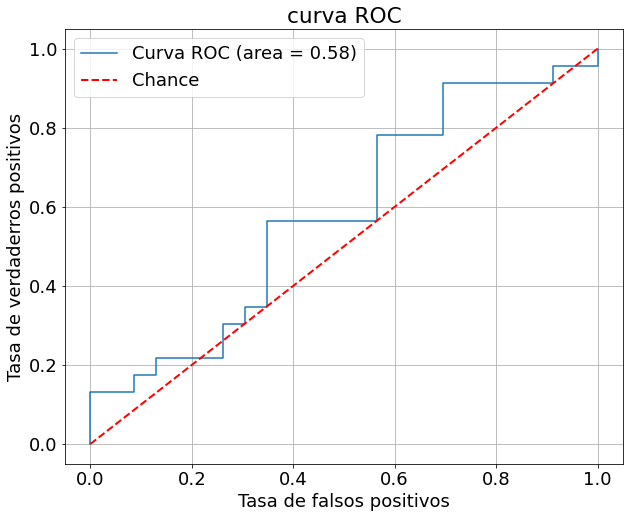

In [218]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [215]:
accuracy_score(y_pred_fro_occ,y_diff)
print(proportion_confint(np.sum(np.equal(y_pred_fro_occ,y_diff)),len(y_diff),method='jeffreys'))
cm = confusion_matrix(y_pred_fro_occ, y_diff)

(0.46457821668324994, 0.7396076472021729)


0.4095238095238095


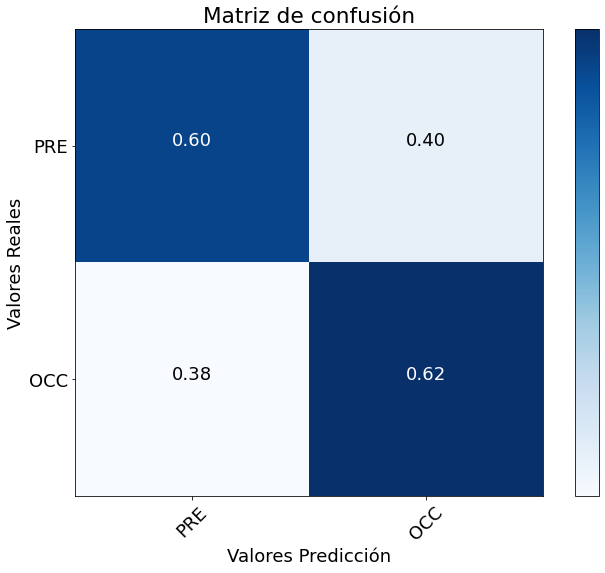

In [229]:

plot_confusion_matrix(cm, ["PRE", "OCC"],normalize=True)